In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import h5py
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [8]:
class RandomHorizontalFlipTensor(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x):
        if random.random() < self.p:
            return torch.flip(x, dims=[2])  
        return x

class RandomVerticalFlipTensor(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x):
        if random.random() < self.p:
            return torch.flip(x, dims=[1])
        return x

class RandomCropTensor(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, x):
        _, h, w = x.shape
        new_h, new_w = self.output_size
        if h == new_h and w == new_w:
            return x
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        return x[:, top: top + new_h, left: left + new_w]

barlow_transform = transforms.Compose([
    RandomHorizontalFlipTensor(p=0.5),
    RandomVerticalFlipTensor(p=0.5),
    RandomCropTensor((112, 112)),
    transforms.Normalize(mean=[0.5]*8, std=[0.5]*8)
])


In [9]:
class UnlabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform
        self.h5_file = None 
        with h5py.File(self.h5_path, 'r') as f:
            self.length = f['jet'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        image = self.h5_file['jet'][idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        view1 = self.transform(image) if self.transform else image
        view2 = self.transform(image) if self.transform else image
        return view1, view2

    def __del__(self):
        if self.h5_file is not None:
            self.h5_file.close()

unlabelled_h5_path = "/kaggle/input/data2-st/unlabelled2/content/Dataset_Specific_Unlabelled.h5"
unlabelled_dataset = UnlabelledDataset(h5_path=unlabelled_h5_path, transform=barlow_transform)
print("Unlabelled dataset size:", len(unlabelled_dataset))

BATCH_SZ_UNLABELLED = 8
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=BATCH_SZ_UNLABELLED, 
                               shuffle=True, drop_last=True, pin_memory=True)


Unlabelled dataset size: 60000


In [10]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

def get_resnet15():
    resnet15 = models.resnet18(pretrained=False)
    resnet15.conv1 = nn.Conv2d(8, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet15.layer4 = nn.Sequential(*list(resnet15.layer4.children())[:1])
    resnet15.fc = Identity()  
    return resnet15

class BarlowTwins(nn.Module):
    def __init__(self, proj_dim=256):
        super(BarlowTwins, self).__init__()
        self.encoder = get_resnet15().to(DEVICE)
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, proj_dim)
        ).to(DEVICE)
        
    def forward(self, x):
        features = self.encoder(x)
        projection = self.projection(features)
        return projection
barlow_model = BarlowTwins(proj_dim=256).to(DEVICE)


The Barlow Twins loss aims to enforce two properties
Invariance: The cross-correlation's diagonal elements (i.e., the similarity between corresponding dimensions of the two views) should be close to 1.
Redundancy Reduction: The off-diagonal elements should be close to 0, ensuring that the representations are not redundant across dimensions.
The loss is computed as the sum of the squared difference between the diagonal elements and 1, plus a weighted sum of the squared off-diagonal elements. The hyperparameter lambd scales the off-diagonal penalty.**

In [11]:
def barlow_twins_loss(z_a, z_b, lambd=5e-3):
    z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0)
    z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0)
    
    batch_size = z_a.size(0)
    c = torch.mm(z_a_norm.T, z_b_norm) / batch_size  
    on_diag = torch.diagonal(c).add_(-1).pow(2).sum()
    off_diag = off_diagonal(c).pow(2).sum()
    loss = on_diag + lambd * off_diag
    return loss

def off_diagonal(x):

    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Barlow Twins Pretraining Epoch 1/10: 100%|██████████| 7500/7500 [06:18<00:00, 19.79it/s]


Epoch 1 completed in 6.316 mins, Avg Loss: 46.1677


Barlow Twins Pretraining Epoch 2/10: 100%|██████████| 7500/7500 [05:18<00:00, 23.55it/s]


Epoch 2 completed in 5.308 mins, Avg Loss: 41.3044


Barlow Twins Pretraining Epoch 3/10: 100%|██████████| 7500/7500 [05:10<00:00, 24.18it/s]


Epoch 3 completed in 5.170 mins, Avg Loss: 40.3630


Barlow Twins Pretraining Epoch 4/10: 100%|██████████| 7500/7500 [04:59<00:00, 25.00it/s]


Epoch 4 completed in 4.999 mins, Avg Loss: 39.9840


Barlow Twins Pretraining Epoch 5/10: 100%|██████████| 7500/7500 [04:54<00:00, 25.49it/s]


Epoch 5 completed in 4.903 mins, Avg Loss: 39.7522


Barlow Twins Pretraining Epoch 6/10: 100%|██████████| 7500/7500 [04:48<00:00, 25.96it/s]


Epoch 6 completed in 4.816 mins, Avg Loss: 39.5299


Barlow Twins Pretraining Epoch 7/10: 100%|██████████| 7500/7500 [04:46<00:00, 26.13it/s]


Epoch 7 completed in 4.783 mins, Avg Loss: 39.5174


Barlow Twins Pretraining Epoch 8/10: 100%|██████████| 7500/7500 [04:47<00:00, 26.07it/s]


Epoch 8 completed in 4.795 mins, Avg Loss: 39.4011


Barlow Twins Pretraining Epoch 9/10: 100%|██████████| 7500/7500 [04:58<00:00, 25.09it/s]


Epoch 9 completed in 4.983 mins, Avg Loss: 39.3603


Barlow Twins Pretraining Epoch 10/10: 100%|██████████| 7500/7500 [04:57<00:00, 25.22it/s]


Epoch 10 completed in 4.956 mins, Avg Loss: 39.3045
Barlow Twins Pretraining completed and model saved as barlow_pretrained_resnet15.pth.


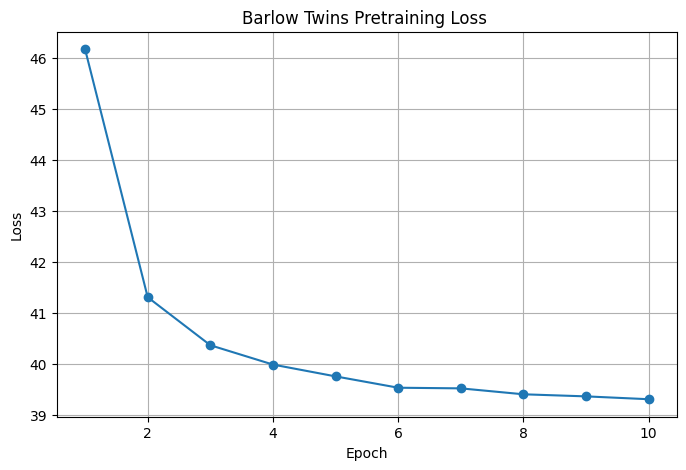

In [12]:
optimizer_barlow = optim.Adam(barlow_model.parameters(), lr=1e-3)
scheduler_barlow = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_barlow, mode='min', factor=0.5, patience=2, verbose=True)

pretrain_epochs = 10
barlow_losses = []
barlow_model.train()

for epoch in range(pretrain_epochs):
    t0 = time.time()
    running_loss = 0.0
    num_batches = 0
    for view1, view2 in tqdm(unlabelled_loader, desc=f"Barlow Twins Pretraining Epoch {epoch+1}/{pretrain_epochs}"):
        view1, view2 = view1.to(DEVICE), view2.to(DEVICE)
        z_a = barlow_model(view1)
        z_b = barlow_model(view2)
        loss = barlow_twins_loss(z_a, z_b, lambd=5e-3)
        
        optimizer_barlow.zero_grad()
        loss.backward()
        optimizer_barlow.step()
        
        running_loss += loss.item()
        num_batches += 1
    avg_loss = running_loss / num_batches
    barlow_losses.append(avg_loss)
    scheduler_barlow.step(avg_loss)
    print(f"Epoch {epoch+1} completed in {(time.time()-t0)/60:.3f} mins, Avg Loss: {avg_loss:.4f}")
    torch.cuda.empty_cache()
torch.save(barlow_model.state_dict(), "barlow_pretrained_resnet15.pth")
print("Barlow Twins Pretraining completed and model saved as barlow_pretrained_resnet15.pth.")

plt.figure(figsize=(8,5))
plt.plot(range(1, pretrain_epochs+1), barlow_losses, marker='o')
plt.title("Barlow Twins Pretraining Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [13]:
class H5LabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform
        self.h5_file = None
        with h5py.File(self.h5_path, 'r') as f:
            self.length = f['jet'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        image = self.h5_file['jet'][idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform is not None:
            image = self.transform(image)
        y = int(self.h5_file['Y'][idx][0])
        m = self.h5_file['m'][idx]
        pt = self.h5_file['pT'][idx]
        reg_target = torch.tensor(np.concatenate([m, pt], axis=0), dtype=torch.float32)
        return image, y, reg_target

    def __del__(self):
        if self.h5_file is not None:
            self.h5_file.close()
labelled_h5_path = "/kaggle/input/data2-st/specific-labelled2/content/Dataset_Specific_labelled_full_only_for_2i.h5"
full_labelled_dataset = H5LabelledDataset(h5_path=labelled_h5_path, transform=barlow_transform)
print("Total labelled dataset size:", len(full_labelled_dataset))
total_len = len(full_labelled_dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len
train_dataset, test_dataset = random_split(full_labelled_dataset, [train_len, test_len])
print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

BATCH_SZ_LABELLED = 64
train_loader_labelled = DataLoader(train_dataset, batch_size=BATCH_SZ_LABELLED, shuffle=True, drop_last=True, pin_memory=True)
test_loader_labelled = DataLoader(test_dataset, batch_size=BATCH_SZ_LABELLED, shuffle=False, drop_last=False, pin_memory=True)


Total labelled dataset size: 10000
Train samples: 8000 Test samples: 2000


In [14]:
class FineTuneClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=2):
        super().__init__()
        self.encoder = pretrained_model.encoder  
        self.linear = nn.Linear(512, num_classes)
        
    def forward(self, x):
        features = self.encoder(x)
        return self.linear(features)
class FineTuneRegressor(nn.Module):
    def __init__(self, pretrained_model, out_dim=2):
        super().__init__()
        self.encoder = pretrained_model.encoder
        self.regressor = nn.Linear(512, out_dim)
        
    def forward(self, x):
        features = self.encoder(x)
        return self.regressor(features)


<ipython-input-24-629331bb828f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load("barlow_pretrained_resnet15.pth", map_location=DEVICE)
Class

Epoch 1 Classification Loss: 0.6222


Classification Epoch 2/10: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]


Epoch 2 Classification Loss: 0.5359


Classification Epoch 3/10: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


Epoch 3 Classification Loss: 0.4925


Classification Epoch 4/10: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


Epoch 4 Classification Loss: 0.4662


Classification Epoch 5/10: 100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


Epoch 5 Classification Loss: 0.4532


Classification Epoch 6/10: 100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


Epoch 6 Classification Loss: 0.4454


Classification Epoch 7/10: 100%|██████████| 125/125 [00:17<00:00,  6.95it/s]


Epoch 7 Classification Loss: 0.4370


Classification Epoch 8/10: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


Epoch 8 Classification Loss: 0.4319


Classification Epoch 9/10: 100%|██████████| 125/125 [00:17<00:00,  7.00it/s]


Epoch 9 Classification Loss: 0.4284


Classification Epoch 10/10: 100%|██████████| 125/125 [00:18<00:00,  6.90it/s]
<ipython-input-24-629331bb828f>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)


Epoch 10 Classification Loss: 0.4265
Fine-tuned (Pretrained) Classification Accuracy: 83.35%


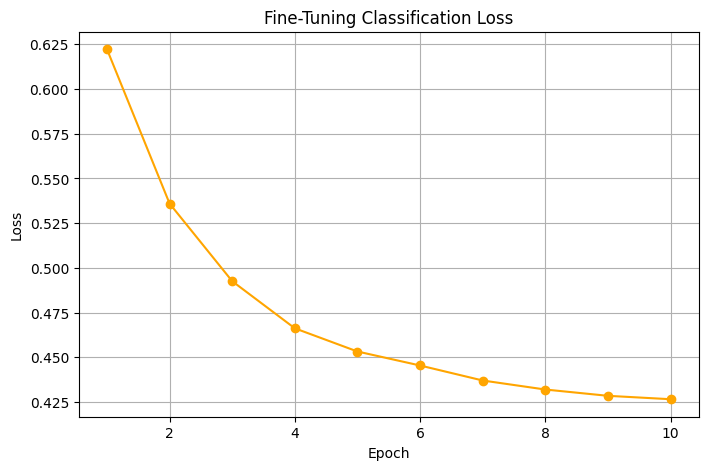

In [24]:
pretrained_weights = torch.load("barlow_pretrained_resnet15.pth", map_location=DEVICE)
barlow_model.load_state_dict(pretrained_weights)

clf_model = FineTuneClassifier(barlow_model).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()

optimizer_clf = optim.Adam([
    {'params': clf_model.encoder.parameters(), 'lr': 1e-5},
    {'params': clf_model.linear.parameters(), 'lr': 1e-4}
])
scheduler_clf = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_cls = 10
cls_losses = []
clf_model.train()

for epoch in range(num_epochs_cls):
    running_loss = 0.0
    for images, y, _ in tqdm(train_loader_labelled, desc=f"Classification Epoch {epoch+1}/{num_epochs_cls}"):
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = clf_model(images)
        loss = criterion_clf(outputs, labels)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    cls_losses.append(avg_loss)
    scheduler_clf.step(avg_loss)
    print(f"Epoch {epoch+1} Classification Loss: {avg_loss:.4f}")

clf_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, y, _ in test_loader_labelled:
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = clf_model(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
clf_acc = 100 * correct / total
print(f"Fine-tuned (Pretrained) Classification Accuracy: {clf_acc:.2f}%")

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs_cls+1), cls_losses, marker='o', color='orange')
plt.title("Fine-Tuning Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Regression Epoch 1/10: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]


Epoch 1 Regression Loss: 154081.6055


Regression Epoch 2/10: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Epoch 2 Regression Loss: 153749.8018


Regression Epoch 3/10: 100%|██████████| 125/125 [00:18<00:00,  6.88it/s]


Epoch 3 Regression Loss: 153400.1381


Regression Epoch 4/10: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


Epoch 4 Regression Loss: 153028.3365


Regression Epoch 5/10: 100%|██████████| 125/125 [00:18<00:00,  6.90it/s]


Epoch 5 Regression Loss: 152637.3734


Regression Epoch 6/10: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Epoch 6 Regression Loss: 152220.1609


Regression Epoch 7/10: 100%|██████████| 125/125 [00:18<00:00,  6.84it/s]


Epoch 7 Regression Loss: 151779.3965


Regression Epoch 8/10: 100%|██████████| 125/125 [00:18<00:00,  6.94it/s]


Epoch 8 Regression Loss: 151315.9452


Regression Epoch 9/10: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Epoch 9 Regression Loss: 150840.5190


Regression Epoch 10/10: 100%|██████████| 125/125 [00:18<00:00,  6.93it/s]


Epoch 10 Regression Loss: 150333.8729
Fine-tuned (Pretrained) Regression MSE: 144999.0938


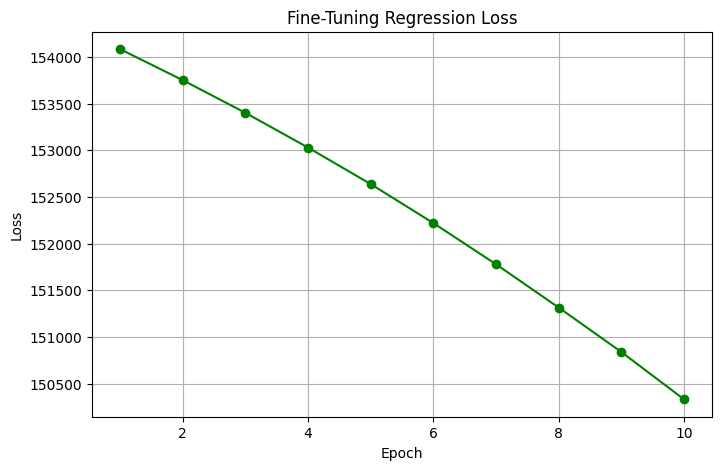

In [16]:

reg_model = FineTuneRegressor(barlow_model).to(DEVICE)
criterion_reg = nn.MSELoss()

optimizer_reg = optim.Adam([
    {'params': reg_model.encoder.parameters(), 'lr': 1e-5},
    {'params': reg_model.regressor.parameters(), 'lr': 1e-4}
])
scheduler_reg = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_reg = 10
reg_losses = []
reg_model.train()

for epoch in range(num_epochs_reg):
    running_loss = 0.0
    for images, _, reg_targets in tqdm(train_loader_labelled, desc=f"Regression Epoch {epoch+1}/{num_epochs_reg}"):
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = reg_model(images)
        loss = criterion_reg(outputs, reg_targets)
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    reg_losses.append(avg_loss)
    scheduler_reg.step(avg_loss)
    print(f"Epoch {epoch+1} Regression Loss: {avg_loss:.4f}")
reg_model.eval()
total_loss = 0.0
with torch.no_grad():
    for images, _, reg_targets in test_loader_labelled:
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = reg_model(images)
        loss = criterion_reg(outputs, reg_targets)
        total_loss += loss.item() * images.size(0)
avg_mse = total_loss / len(test_dataset)
print(f"Fine-tuned (Pretrained) Regression MSE: {avg_mse:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs_reg+1), reg_losses, marker='o', color='green')
plt.title("Fine-Tuning Regression ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


i have implemented a vgg 11 model for comparison

In [17]:
class VGG(nn.Module):
    def __init__(self, num_classes=2, regression_out=2, mode='classification'):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))
        self.mode = mode
        if mode == 'classification':
            self.classifier = nn.Sequential(
                nn.Linear(512 * 3 * 3, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        else:  
            self.regressor = nn.Sequential(
                nn.Linear(512 * 3 * 3, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, regression_out)
            )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if self.mode == 'classification':
            x = self.classifier(x)
        else:
            x = self.regressor(x)
        return x


In [18]:
vgg_classifier = VGG(num_classes=2, mode='classification').to(DEVICE)
criterion_vgg_clf = nn.CrossEntropyLoss()
optimizer_vgg_clf = optim.Adam(vgg_classifier.parameters(), lr=1e-3)
num_epochs_vgg_cls = 10

vgg_cls_losses = []
vgg_classifier.train()
for epoch in range(num_epochs_vgg_cls):
    running_loss = 0.0
    for images, y, _ in tqdm(train_loader_labelled, desc=f"VGG Classification Epoch {epoch+1}/{num_epochs_vgg_cls}"):
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = vgg_classifier(images)
        loss = criterion_vgg_clf(outputs, labels)
        optimizer_vgg_clf.zero_grad()
        loss.backward()
        optimizer_vgg_clf.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    vgg_cls_losses.append(avg_loss)
    print(f"Epoch {epoch+1} VGG Classification Loss: {avg_loss:.4f}")

vgg_classifier.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, y, _ in test_loader_labelled:
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = vgg_classifier(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
vgg_cls_acc = 100 * correct / total
print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
torch.save(vgg_classifier.state_dict(), "scratch_vgg_classifier.pth")



VGG Classification Epoch 1/10:   0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-18-822824c94d8f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
VGG Classification Epoch 1/10: 100%|██████████| 125/125 [00:28<00:00,  4.45it/s]


Epoch 1 VGG Classification Loss: 0.8688


VGG Classification Epoch 2/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 2 VGG Classification Loss: 0.8032


VGG Classification Epoch 3/10: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]


Epoch 3 VGG Classification Loss: 0.6936


VGG Classification Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


Epoch 4 VGG Classification Loss: 0.6932


VGG Classification Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 5 VGG Classification Loss: 0.6931


VGG Classification Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


Epoch 6 VGG Classification Loss: 0.6931


VGG Classification Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 7 VGG Classification Loss: 0.7001


VGG Classification Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]


Epoch 8 VGG Classification Loss: 0.6937


VGG Classification Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.55it/s]


Epoch 9 VGG Classification Loss: 0.6936


VGG Classification Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]
<ipython-input-18-822824c94d8f>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)


Epoch 10 VGG Classification Loss: 0.6931
Scratch VGG Classification Accuracy: 50.90%


In [19]:

vgg_regressor = VGG(regression_out=2, mode='regression').to(DEVICE)
criterion_vgg_reg = nn.MSELoss()
optimizer_vgg_reg = optim.Adam(vgg_regressor.parameters(), lr=1e-3)
num_epochs_vgg_reg = 10

vgg_reg_losses = []
vgg_regressor.train()
for epoch in range(num_epochs_vgg_reg):
    running_loss = 0.0
    for images, _, reg_targets in tqdm(train_loader_labelled, desc=f"VGG Regression Epoch {epoch+1}/{num_epochs_vgg_reg}"):
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = vgg_regressor(images)
        loss = criterion_vgg_reg(outputs, reg_targets)
        optimizer_vgg_reg.zero_grad()
        loss.backward()
        optimizer_vgg_reg.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    vgg_reg_losses.append(avg_loss)
    print(f"Epoch {epoch+1} VGG Regression Loss: {avg_loss:.4f}")

vgg_regressor.eval()
total_loss = 0.0
with torch.no_grad():
    for images, _, reg_targets in test_loader_labelled:
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = vgg_regressor(images)
        loss = criterion_vgg_reg(outputs, reg_targets)
        total_loss += loss.item() * images.size(0)
vgg_avg_mse = total_loss / len(test_dataset)
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")
torch.save(vgg_regressor.state_dict(), "scratch_vgg_regressor.pth")


VGG Regression Epoch 1/10: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch 1 VGG Regression Loss: 63909.5089


VGG Regression Epoch 2/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 2 VGG Regression Loss: 10484.6019


VGG Regression Epoch 3/10: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 3 VGG Regression Loss: 9148.5902


VGG Regression Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 4 VGG Regression Loss: 9320.3866


VGG Regression Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 5 VGG Regression Loss: 8329.3094


VGG Regression Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 6 VGG Regression Loss: 8553.6003


VGG Regression Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


Epoch 7 VGG Regression Loss: 8142.2490


VGG Regression Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 8 VGG Regression Loss: 8183.5703


VGG Regression Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 9 VGG Regression Loss: 8034.2474


VGG Regression Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


Epoch 10 VGG Regression Loss: 7853.1873
Scratch VGG Regression MSE: 5901.8886


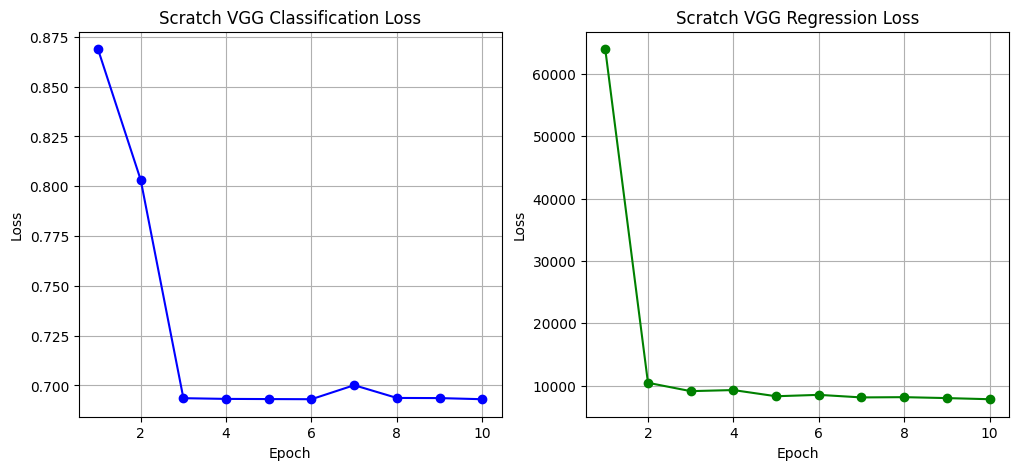

Scratch VGG Classification Accuracy: 50.90%
Scratch VGG Regression MSE: 5901.8886


In [20]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs_vgg_cls+1), vgg_cls_losses, marker='o', color='blue')
plt.title("Scratch VGG Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs_vgg_reg+1), vgg_reg_losses, marker='o', color='green')
plt.title("Scratch VGG Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")


In [25]:
torch.save(clf_model.state_dict(), "finetuned_classifier.pth")
torch.save(reg_model.state_dict(), "finetuned_regressor.pth")

torch.save(vgg_classifier.state_dict(), "scratch_vgg_classifier.pth")
torch.save(vgg_regressor.state_dict(), "scratch_vgg_regressor.pth")

print(f"Fine-tuned Classification Accuracy: {clf_acc:.2f}%")
print(f"Fine-tuned Regression MSE: {avg_mse:.4f}")
print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")




Fine-tuned Classification Accuracy: 83.35%
Fine-tuned Regression MSE: 144999.0938
Scratch VGG Classification Accuracy: 50.90%
Scratch VGG Regression MSE: 5901.8886


In [22]:
!zip -r models.zip barlow_pretrained_resnet15.pth finetuned_classifier.pth finetuned_regressor.pth scratch_vgg_classifier.pth scratch_vgg_regressor.pth

  adding: barlow_pretrained_resnet15.pth (deflated 7%)
  adding: finetuned_classifier.pth (deflated 7%)
  adding: finetuned_regressor.pth (deflated 7%)
  adding: scratch_vgg_classifier.pth (deflated 8%)
  adding: scratch_vgg_regressor.pth (deflated 8%)


In [26]:
from IPython.display import FileLink
FileLink("models.zip")

/kaggle/working/models.zip